## Importing libraries




In [1]:
# mount the google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install lightgbm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import pandas as pd
import numpy as np
from datetime import datetime, date, timedelta
from tqdm import tqdm
import calendar as ca
from os import listdir
from os.path import join

import time
import gc
import pickle

import lightgbm as lgb
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.layers import PReLU
# from keras.layers.normalization import BatchNormalization
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import LSTM
from tensorflow.keras import callbacks
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import mean_squared_error, mean_absolute_error

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.style
import matplotlib as mpl
import seaborn as sns
import warnings
mpl.style.use('classic')
%matplotlib inline


## Loading the dataset

In [3]:
# load train data starting from 01.01.2016 from gdrive
types = {'id': 'int64',
                'item_nbr': 'int32',
                'store_nbr': 'int8',
                'unit_sales': 'float32'
            }
data_folder = "drive/My Drive/favorita/data/"

train_large = pd.read_csv(f"{data_folder}/train.csv", parse_dates = ['date'], dtype = types, 
                           converters={'unit_sales': lambda u: np.log1p(float(u)) if float(u) > 0 else 0}
                          , infer_datetime_format = True, low_memory = True, skiprows=range(1, 66458909))


/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: ParserWarning: Both a converter and dtype were specified for column unit_sales - only the converter will be used
  return func(*args, **kwargs)


In [125]:
# load other data
items = pd.read_csv(f"{data_folder}/items.csv")
holiday_events = pd.read_csv(f"{data_folder}/holidays_events.csv", parse_dates=['date'])
stores = pd.read_csv(f"{data_folder}/stores.csv")
oil = pd.read_csv(f"{data_folder}/oil.csv", parse_dates=['date'])
transactions = pd.read_csv(f"{data_folder}/transactions.csv", parse_dates=['date'])
weather = pd.read_csv(f"{data_folder}/weather.csv", parse_dates=['Date'])


In [126]:
weather.rename(columns={'Date':'date', 'location':'city'}, inplace=True)
# dropping ALL duplicte values 
weather.drop_duplicates(keep = 'first', inplace = True)

In [127]:
stores['city'] = stores.city.str.lower()
weather_store = pd.merge(stores[['store_nbr', 'city']], weather[['date', 'AvgTemp', 'city']], on='city',how="left")

In [128]:
# encode the categorical values
le = LabelEncoder()
items['family_en'] = le.fit_transform(items['family'].values)

stores['city_en'] = le.fit_transform(stores['city'].values)
stores['state_en'] = le.fit_transform(stores['state'].values)
stores['type_en'] = le.fit_transform(stores['type'].values)

## Data transformation

In [8]:
# filter out only the 20 stores for the anlysis for colab( if running for 54 stores may need to run in separate server)
SELECTED_STORES = [i for i in range(1, 20)]
train_selected = train_large.loc[(train_large.store_nbr.isin(SELECTED_STORES)) & (train_large.date >= datetime(2017, 1, 1))]


In [9]:
# merge and transform the AvgTemp to format of temporal sequence
train_selected_ext = pd.merge(train_selected, weather_store[['date', 'store_nbr',  'AvgTemp']],on=["store_nbr",'date'],how="left")  # Merge weather
train_selected_ext.rename(columns={'AvgTemp': 'avg_temp'}, inplace=True)
train_selected_temp = train_selected_ext.set_index(["store_nbr", "item_nbr", "date"])[["avg_temp"]].unstack(level=-1).fillna(0)
train_selected_temp.columns = train_selected_temp.columns.get_level_values(1)
del train_selected_ext

In [10]:
# merge and transform the promotion to format of temporal sequence
train_selected_promotion = train_selected.set_index(["store_nbr", "item_nbr", "date"])[["onpromotion"]].unstack(level=-1).fillna(False)
train_selected_promotion.columns = train_selected_promotion.columns.get_level_values(1)

In [11]:
# merge and transform the unit_sales to format of temporal sequence
# this is used to create mean encoding/target encoding/historic unit sales
train_selected_sales = train_selected.set_index(["store_nbr", "item_nbr", "date"])[["unit_sales"]].unstack(level=-1).fillna(0)
train_selected_sales.columns = train_selected_sales.columns.get_level_values(1)


In [12]:
# Item dataframe reindex with transformed indexes from unit_sales
items_reindexed = items.set_index('item_nbr')
items_reindexed = items_reindexed.reindex(train_selected_sales.index.get_level_values(1))

In [36]:
items_reindexed

,family,class,perishable,family_en
item_nbr,,,,
96995,GROCERY I,1093,0,12
99197,GROCERY I,1067,0,12
103520,GROCERY I,1028,0,12
103665,BREAD/BAKERY,2712,1,5
105574,GROCERY I,1045,0,12
...,...,...,...,...
2110456,BEVERAGES,1120,0,3
2111684,BEVERAGES,1120,0,3
2113343,BEVERAGES,1114,0,3


In [13]:
# stores dataframe reindex with transformed indexes from unit_sales
stores_reindexed = stores.set_index('store_nbr')
stores_reindexed = stores_reindexed.reindex(train_selected_sales.index.get_level_values(0))

## Utility Methods

In [14]:
# get timespan for feature creation
def get_timespan(df, dt, minus, periods, freq='D'):
    return df[pd.date_range(dt - timedelta(days=minus), periods=periods, freq=freq)]

In [38]:
# prepare features with seasonal patterns/ mean encoding
def prepare_dataset_1(t2017, is_train=True):
    X = pd.DataFrame({
        "perishable": items_reindexed["perishable"].values,
        "perishable": items_reindexed["perishable"].values,
        "family": items_reindexed["family_en"].values,
        "item_class": items_reindexed["class"].values,
        "type": stores_reindexed["type_en"].values,
        "cluster": stores_reindexed["cluster"].values,
        "state": stores_reindexed["state_en"].values,
        "day_1_2017": get_timespan(train_selected_sales, t2017, 1, 1).values.ravel(),
        "mean_3_2017": get_timespan(train_selected_sales, t2017, 3, 3).mean(axis=1).values,
        "mean_7_2017": get_timespan(train_selected_sales, t2017, 7, 7).mean(axis=1).values,
        "mean_14_2017": get_timespan(train_selected_sales, t2017, 14, 14).mean(axis=1).values,
        "mean_30_2017": get_timespan(train_selected_sales, t2017, 30, 30).mean(axis=1).values,
        "mean_60_2017": get_timespan(train_selected_sales, t2017, 60, 60).mean(axis=1).values,
        "mean_140_2017": get_timespan(train_selected_sales, t2017, 140, 140).mean(axis=1).values,
        "promo_14_2017": get_timespan(train_selected_promotion, t2017, 14, 14).sum(axis=1).values,
        "promo_60_2017": get_timespan(train_selected_promotion, t2017, 60, 60).sum(axis=1).values,
        "promo_140_2017": get_timespan(train_selected_promotion, t2017, 140, 140).sum(axis=1).values,
        "day_1_temp": get_timespan(train_selected_temp, t2017, 1, 1).values.ravel(),
        "mean_3_temp": get_timespan(train_selected_temp, t2017, 3, 3).mean(axis=1).values,
        "mean_7_temp": get_timespan(train_selected_temp, t2017, 7, 7).mean(axis=1).values
    })
    for i in range(7):
        X['mean_4_dow{}_2017'.format(i)] = get_timespan(train_selected_sales, t2017, 28-i, 4, freq='7D').mean(axis=1).values
        X['mean_20_dow{}_2017'.format(i)] = get_timespan(train_selected_sales, t2017, 140-i, 20, freq='7D').mean(axis=1).values
    # for i in range(16):
    #     X["promo_{}".format(i)] = train_selected_promotion[t2017 + timedelta(days=i)].values.astype(np.uint8)
    #     # X["holiday_{}".format(i)] = holiday_2017[t2017 + timedelta(days=i)].values.astype(np.uint8)
    if is_train:
        y = train_selected_sales[
            pd.date_range(t2017, periods=16)
        ].values
        return X, y
    return X

In [37]:
# basic features from existing data
def prepare_dataset_basic(t2017, is_train=True):
    X = pd.DataFrame({
        "temp": train_selected_temp[t2017.strftime('%Y-%m-%d')].values,
        "promotion": train_selected_promotion[t2017.strftime('%Y-%m-%d')],
        "perishable": items_reindexed["perishable"].values,
        "family": items_reindexed["family_en"].values,
        "item_class": items_reindexed["class"].values,
        "type": stores_reindexed["type_en"].values,
        "cluster": stores_reindexed["cluster"].values,
        "state": stores_reindexed["state_en"].values,


    })
    if is_train:
        y = train_selected_sales[
            pd.date_range(t2017, periods=16)
        ].values
        return X, y
    return X

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

def get_error(weights, true_val, pred_val, predict_days_ahead=16):

    mse = mean_squared_error(true_val, pred_val, sample_weight=weights)
    rmse = np.sqrt(mse)

    mae = mean_absolute_error(true_val, pred_val, sample_weight=weights)

    #mape = np.mean(np.abs((true_val - pred_val) / true_val)) * 100

    try:
        err = (true_val - pred_val) ** 2
        err = err.sum(axis=1) * weights
        nwrmsle = np.sqrt(err.sum() / weights.sum() / predict_days_ahead)
    except:
        nwrmsle = rmse

    return mse, rmse, nwrmsle, mae

In [ ]:
def plotImp(model, X , num = 20):
    feature_imp = pd.DataFrame({'Value':model.feature_importance(),'Feature':X.columns})
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", 
                                                        ascending=False)[0:num])
    plt.title('LightGBM Features')
    plt.tight_layout()
    plt.savefig('lgbm_importances-01.png')
    plt.show()

## Baseline Model

In [17]:
t2017 = date(2017, 5, 8)
test2017 = date(2017, 7, 31)

In [19]:
MA_train_set = train_selected[train_selected["date"]<=t2017.strftime('%Y-%m-%d')].reset_index()
MA_test_set = train_selected[train_selected["date"]>=test2017.strftime('%Y-%m-%d')].reset_index().set_index(['item_nbr', 'store_nbr'])

In [20]:
# Item dataframe reindex with transformed indexes from unit_sales
items_reindexed_base = items.set_index('item_nbr')
items_reindexed_base = items_reindexed_base.reindex(MA_test_set.index.get_level_values(0))

In [21]:
MA_train_set.loc[:, "unit_sales"].fillna(0, inplace=True)

In [22]:
#Moving Averages
for i in [28]:
    val='MA'+str(i)
    tmp = MA_train_set[MA_train_set.date>(t2017-timedelta(int(i))).strftime('%Y-%m-%d')]
    tmp1 = tmp.groupby(['item_nbr', 'store_nbr'])['unit_sales'].mean().to_frame(val)
    MA_test_set = MA_test_set.join(tmp1, how='left')




In [23]:
#Median of MAs
MA_test_set['unit_sales_pred']=MA_test_set.iloc[:,5:].median(axis=1)
MA_test_set.loc[:, "unit_sales_pred"].fillna(0, inplace=True)

In [24]:
MA_test_set['unit_sales_actual'] = MA_test_set['unit_sales'].apply(pd.np.expm1) # restoring unit values
MA_test_set['unit_sales_pred_actual'] = MA_test_set['unit_sales_pred'].apply(pd.np.expm1) # restoring unit values

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  


In [25]:
MA_test_set

index         id       date  unit_sales  onpromotion  \
item_nbr store_nbr                                                            
96995    1          57360788  123819696 2017-07-31    1.098612        False   
         1          57576551  124035459 2017-08-02    0.693147        False   
         1          57683958  124142866 2017-08-03    1.098612        False   
         1          58001260  124460168 2017-08-06    1.098612        False   
         1          58112102  124571010 2017-08-07    1.098612        False   
...                      ...        ...        ...         ...          ...   
2127114  8          58533907  124992815 2017-08-11    1.098612        False   
         8          58638899  125097807 2017-08-12    1.609438        False   
         8          58744016  125202924 2017-08-13    2.079442        False   
         8          58850430  125309338 2017-08-14    0.693147        False   
         8          58952882  125411790 2017-08-15    0.693147        False   

                        MA28  unit_sales_pred  unit_sales_actual  \
item_nbr store_nbr                                                 
96995    1          0.876249         0.876249                2.0   
         1          0.876249         0.876249                1.0   
         1          0.876249         0.876249                2.0   
         1          0.876249         0.876249                2.0   
         1          0.876249         0.876249                2.0   
...                      ...              ...                ...   
2127114  8               NaN         0.000000                2.0   
         8               NaN         0.000000                4.0   
         8               NaN         0.000000                7.0   
         8               NaN         0.000000                1.0   
         8               NaN         0.000000                1.0   

                    unit_sales_pred_actual  
item_nbr store_nbr                          
96995    1                        1.401874  
         1                        1.401874  
         1                        1.401874  
         1                        1.401874  
         1                        1.401874  
...                                    ...  
2127114  8                        0.000000  
         8                        0.000000  
         8                        0.000000  
         8                        0.000000  
         8                        0.000000  

[570959 rows x 9 columns]

In [27]:
# errors for model
weights = items_reindexed_base["perishable"].values * 0.25 + 1
print('Unit', get_error(weights, MA_test_set['unit_sales_actual'].values, MA_test_set["unit_sales_pred_actual"].values))
print('Log', get_error(weights, MA_test_set['unit_sales'].values, MA_test_set["unit_sales_pred"].values))

Unit (139.02818907874033, 11.791021545173273, 11.791021545173273, 3.5338068575593717, nan)
Log (0.3868461208515245, 0.621969549778383, 0.621969549778383, 0.4595248600458542, nan)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


In [30]:
out_filename = 'drive/My Drive/favorita/model_outputs/' + 'MA_log_scaled_out_base.pkl'
MA_test_set.to_pickle(out_filename)

## Basic Model

In [192]:
# date range use for training data
t2017 = date(2017, 5, 8)
for i in range(6):
    delta = timedelta(days=7 * i)
    print(t2017 + delta)

2017-05-08
2017-05-15
2017-05-22
2017-05-29
2017-06-05
2017-06-12


In [39]:
print("Preparing dataset...basic")

t2017 = date(2017, 5, 8)
X_l, y_l = [], []
for i in range(6):
    delta = timedelta(days=7 * i)
    X_tmp, y_tmp = prepare_dataset_basic(t2017 + delta)
    X_l.append(X_tmp)
    y_l.append(y_tmp)

X_train = pd.concat(X_l, axis=0)
y_train = np.concatenate(y_l, axis=0)
del X_l, y_l
X_val, y_val = prepare_dataset_basic(date(2017, 7, 10))
X_test, y_test = prepare_dataset_basic(date(2017, 7, 31))

Preparing dataset...basic


In [40]:
params = {
    'num_leaves': 60,
    'objective': 'regression_l2',
    'max_depth': 10,
    'min_data_per_leaf': 300,
    'learning_rate': 0.05,
    'boosting_type': 'gbdt',
    'colsample_bytree': 0.4,
    'feature_fraction': 0.75,
    'bagging_fraction': 0.75,
    'bagging_freq': 1,
    'metric': 'l2',
    'num_threads': 4
}

In [41]:
MAX_ROUNDS = 1000
val_pred = []
test_pred = []
cate_vars = []
feature_importance_data = []

for i in range(16):

    print("=" * 50)
    print("Step %d" % (i+1))
    print("=" * 50)

    dtrain = lgb.Dataset(
        X_train, label=y_train[:, i],
        categorical_feature=cate_vars,
        weight=pd.concat([items_reindexed["perishable"]]*6) * 0.25 + 1
    )
    dval = lgb.Dataset(
        X_val, label=y_val[:, i], reference=dtrain,
        weight=items_reindexed["perishable"].values * 0.25 + 1,
        categorical_feature=cate_vars)
    bst = lgb.train(
        params, dtrain, num_boost_round=MAX_ROUNDS,
        valid_sets=[dtrain, dval], early_stopping_rounds=50, verbose_eval=50
    )

    f_importance = ["Step {}".format(i)] + [fx for fx in bst.feature_importance("gain")]
    feature_importance_data.append(f_importance)

    val_pred.append(bst.predict(
        X_val, num_iteration=bst.best_iteration or MAX_ROUNDS))
    test_pred.append(bst.predict(
        X_test, num_iteration=bst.best_iteration or MAX_ROUNDS))

    # Save model
    with open('lgb_step_{}.pickle'.format(i), 'wb') as file:
        pickle.dump(bst, file)



Step 1


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds.
[50]	training's l2: 0.374876	valid_1's l2: 0.371112
[100]	training's l2: 0.342725	valid_1's l2: 0.342637
[150]	training's l2: 0.337634	valid_1's l2: 0.339156
[200]	training's l2: 0.334711	valid_1's l2: 0.337473
[250]	training's l2: 0.332868	valid_1's l2: 0.336221
[300]	training's l2: 0.3314	valid_1's l2: 0.335401
[350]	training's l2: 0.330198	valid_1's l2: 0.334875
[400]	training's l2: 0.329338	valid_1's l2: 0.334393
[450]	training's l2: 0.3286	valid_1's l2: 0.33399
[500]	training's l2: 0.327837	valid_1's l2: 0.333547
[550]	training's l2: 0.327269	valid_1's l2: 0.333331
[600]	training's l2: 0.326748	valid_1's l2: 0.333224
[650]	training's l2: 0.326271	valid_1's l2: 0.333136
[700]	training's l2: 0.32588	valid_1's l2: 0.332906
[750]	training's l2: 0.325456	valid_1's l2: 0.332827
[800]	training's l2: 0.325105	valid_1's l2: 0.332788
[850]	training's l2: 0.324798	valid_1's l2: 0.332655
[900]	training's l2: 0.324507	valid_1's l2: 

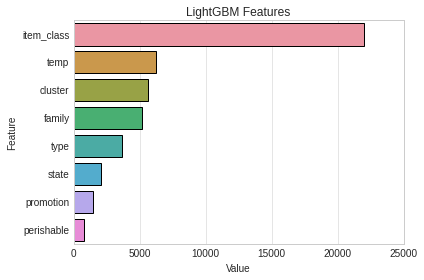

In [42]:

# feature importance graph
warnings.simplefilter(action='ignore', category=FutureWarning)
plt.style.use('seaborn-whitegrid')

plotImp(bst,X_train)

In [43]:
print("Validation LOG mse:", mean_squared_error(y_val, np.array(val_pred).transpose(), sample_weight=(items_reindexed["perishable"].values * 0.25 + 1)))
print("Test LOG mse:", mean_squared_error(y_test, np.array(test_pred).transpose(), sample_weight=(items_reindexed["perishable"].values * 0.25 + 1)))

print("Validation mse:", mean_squared_error(np.clip(np.expm1(y_val), 0, 1000), np.clip(np.expm1(np.array(val_pred).transpose()), 0, 1000), sample_weight=(items_reindexed["perishable"].values * 0.25 + 1)))
print("Test mse:", mean_squared_error(np.clip(np.expm1(y_test), 0, 1000), np.clip(np.expm1(np.array(test_pred).transpose()), 0, 1000), sample_weight=(items_reindexed["perishable"].values * 0.25 + 1)))

Validation LOG mse: 0.638039143942974
Test LOG mse: 0.6420420039587773
Validation mse: 135.167216491934
Test mse: 147.66461261703074


In [44]:
print("Combine with the test data split...")

df_preds_lg = pd.DataFrame(
    np.array(test_pred).transpose(), index=train_selected_sales.index,
    columns=pd.date_range("2017-07-31", periods=16)
).stack().to_frame("log_predicted_unit_sales")
df_preds_lg.index.set_names(["store_nbr", "item_nbr", "date"], inplace=True)

df_test_lg = pd.DataFrame(
    y_test, index=train_selected_sales.index,
    columns=pd.date_range("2017-07-31", periods=16)
).stack().to_frame("log_actual_unit_sales")
df_test_lg.index.set_names(["store_nbr", "item_nbr", "date"], inplace=True)


comb_df = pd.concat([df_preds_lg, df_test_lg], axis=1)
comb_df['predicted_unit_sales'] = np.clip(np.expm1(comb_df["log_predicted_unit_sales"]), 0, 1000)
comb_df['actual_unit_sales'] = np.clip(np.expm1(comb_df["log_actual_unit_sales"]), 0, 1000)
# comb_df['perishable'] = df_items_2017["perishable"]

Combine with the test data split...


In [45]:
out_filename = 'drive/My Drive/favorita/model_outputs/' + 'lgbm_log_scaled_out_base.pkl'
merge_df = pd.merge(comb_df.reset_index(), items.reset_index(), on='item_nbr',how="left")
merge_df.to_pickle(out_filename)

In [215]:
merge_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14632384 entries, 0 to 14632383
Data columns (total 10 columns):
 #   Column                    Dtype         
---  ------                    -----         
 0   store_nbr                 int64         
 1   item_nbr                  int64         
 2   date                      datetime64[ns]
 3   log_predicted_unit_sales  float64       
 4   log_actual_unit_sales     float64       
 5   predicted_unit_sales      float64       
 6   actual_unit_sales         float64       
 7   family                    int64         
 8   class                     int64         
 9   perishable                int64         
dtypes: datetime64[ns](1), float64(4), int64(5)
memory usage: 1.2 GB


In [47]:
# errors for model
weights = merge_df["perishable"].values * 0.25 + 1
print('Unit', get_error(weights, merge_df['actual_unit_sales'].values, merge_df["predicted_unit_sales"].values))
print('Log', get_error(weights, merge_df['log_actual_unit_sales'].values, merge_df["log_predicted_unit_sales"].values))

Unit (147.6646126170308, 12.151732905928718, 12.151732905928718, 3.59257736530841, nan)
Log (0.6420420039587776, 0.80127523608232, 0.80127523608232, 0.6211503262601399, inf)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


## Model 2 (with engineered features)

In [49]:
print("Preparing dataset...1")

t2017 = date(2017, 5, 22)
X_l, y_l = [], []
for i in range(4):
    delta = timedelta(days=7 * i)
    X_tmp, y_tmp = prepare_dataset_1(t2017 + delta)
    X_l.append(X_tmp)
    y_l.append(y_tmp)

X_train = pd.concat(X_l, axis=0)
y_train = np.concatenate(y_l, axis=0)
del X_l, y_l
X_val, y_val = prepare_dataset_1(date(2017, 7, 10))
X_test, y_test = prepare_dataset_1(date(2017, 7, 31))

Preparing dataset...1


In [44]:
print("Preparing dataset...1")

t2017 = date(2017, 5, 24)
X_l, y_l = [], []
for i in range(6):
    delta = timedelta(days=7 * i)
    X_tmp, y_tmp = prepare_dataset_1(t2017 + delta)
    X_l.append(X_tmp)
    y_l.append(y_tmp)

X_train = pd.concat(X_l, axis=0)
y_train = np.concatenate(y_l, axis=0)
del X_l, y_l
X_val, y_val = prepare_dataset_1(date(2017, 7, 12))
X_test, y_test = prepare_dataset_1(date(2017, 7, 31))

Preparing dataset...1


In [50]:
params = {
    'num_leaves': 60,
    'objective': 'regression_l2',
    'max_depth': 10,
    'min_data_per_leaf': 300,
    'learning_rate': 0.05,
    'boosting_type': 'gbdt',
    'colsample_bytree': 0.4,
    'feature_fraction': 0.75,
    'bagging_fraction': 0.75,
    'bagging_freq': 1,
    'metric': 'l2',
    'num_threads': 4
}

In [51]:
MAX_ROUNDS = 1000
val_pred = []
test_pred = []
cate_vars = []
feature_importance_data = []

for i in range(16):

    print("=" * 50)
    print("Step %d" % (i+1))
    print("=" * 50)

    dtrain = lgb.Dataset(
        X_train, label=y_train[:, i],
        categorical_feature=cate_vars,
        weight=pd.concat([items_reindexed["perishable"]]*4) * 0.25 + 1
    )
    dval = lgb.Dataset(
        X_val, label=y_val[:, i], reference=dtrain,
        weight=items_reindexed["perishable"].values * 0.25 + 1,
        categorical_feature=cate_vars)
    bst = lgb.train(
        params, dtrain, num_boost_round=MAX_ROUNDS,
        valid_sets=[dtrain, dval], early_stopping_rounds=50, verbose_eval=50
    )

    f_importance = ["Step {}".format(i)] + [fx for fx in bst.feature_importance("gain")]
    feature_importance_data.append(f_importance)

    val_pred.append(bst.predict(
        X_val, num_iteration=bst.best_iteration or MAX_ROUNDS))
    test_pred.append(bst.predict(
        X_test, num_iteration=bst.best_iteration or MAX_ROUNDS))

    # Save model
    with open('lgb_step_{}.pickle'.format(i), 'wb') as file:
        pickle.dump(bst, file)


Step 1


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds.
[50]	training's l2: 0.340534	valid_1's l2: 0.327607
[100]	training's l2: 0.327159	valid_1's l2: 0.321024
[150]	training's l2: 0.322415	valid_1's l2: 0.320646
[200]	training's l2: 0.318979	valid_1's l2: 0.320614
Early stopping, best iteration is:
[162]	training's l2: 0.321555	valid_1's l2: 0.320603
Step 2
Training until validation scores don't improve for 50 rounds.
[50]	training's l2: 0.348013	valid_1's l2: 0.34148
[100]	training's l2: 0.335602	valid_1's l2: 0.33507
[150]	training's l2: 0.33091	valid_1's l2: 0.3348
[200]	training's l2: 0.327364	valid_1's l2: 0.334733
Early stopping, best iteration is:
[178]	training's l2: 0.328781	valid_1's l2: 0.334715
Step 3
Training until validation scores don't improve for 50 rounds.
[50]	training's l2: 0.356839	valid_1's l2: 0.337571
[100]	training's l2: 0.343918	valid_1's l2: 0.33412
Early stopping, best iteration is:
[86]	training's l2: 0.345902	valid_1's l2: 0.333861
Step 4
Training 

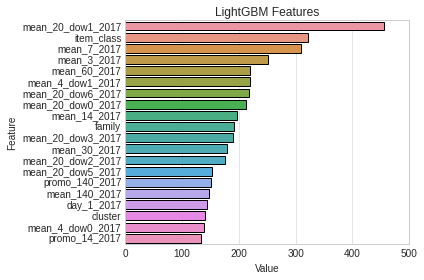

In [52]:
# feature importance graph
warnings.simplefilter(action='ignore', category=FutureWarning)
plt.style.use('seaborn-whitegrid')

plotImp(bst,X_train)

In [53]:
print("Validation LOG mse:", mean_squared_error(y_val, np.array(val_pred).transpose(), sample_weight=(items_reindexed["perishable"].values * 0.25 + 1)))
print("Test LOG mse:", mean_squared_error(y_test, np.array(test_pred).transpose(), sample_weight=(items_reindexed["perishable"].values * 0.25 + 1)))

print("Validation mse:", mean_squared_error(np.clip(np.expm1(y_val), 0, 1000), np.clip(np.expm1(np.array(val_pred).transpose()), 0, 1000), sample_weight=(items_reindexed["perishable"].values * 0.25 + 1)))
print("Test mse:", mean_squared_error(np.clip(np.expm1(y_test), 0, 1000), np.clip(np.expm1(np.array(test_pred).transpose()), 0, 1000), sample_weight=(items_reindexed["perishable"].values * 0.25 + 1)))

Validation LOG mse: 0.3741170495951862
Test LOG mse: 0.3777183866496703
Validation mse: 63.35742517845878
Test mse: 76.36082252571566


In [54]:
print("Combine with the test data split...")

df_preds_lg = pd.DataFrame(
    np.array(test_pred).transpose(), index=train_selected_sales.index,
    columns=pd.date_range("2017-07-31", periods=16)
).stack().to_frame("log_predicted_unit_sales")
df_preds_lg.index.set_names(["store_nbr", "item_nbr", "date"], inplace=True)

df_test_lg = pd.DataFrame(
    y_test, index=train_selected_sales.index,
    columns=pd.date_range("2017-07-31", periods=16)
).stack().to_frame("log_actual_unit_sales")
df_test_lg.index.set_names(["store_nbr", "item_nbr", "date"], inplace=True)


comb_df = pd.concat([df_preds_lg, df_test_lg], axis=1)
comb_df['predicted_unit_sales'] = np.clip(np.expm1(comb_df["log_predicted_unit_sales"]), 0, 1000)
comb_df['actual_unit_sales'] = np.clip(np.expm1(comb_df["log_actual_unit_sales"]), 0, 1000)
# comb_df['perishable'] = df_items_2017["perishable"]

Combine with the test data split...


In [55]:
# save data to file
out_filename = 'drive/My Drive/favorita/model_outputs/' + 'lgbm_log_scaled_out_fe_model.pkl'
merge_df = pd.merge(comb_df.reset_index(), items.reset_index(), on='item_nbr',how="left")
merge_df.to_pickle(out_filename)

In [ ]:
merge_df.date.min(), merge_df.date.max()

(Timestamp('2017-07-31 00:00:00'), Timestamp('2017-08-15 00:00:00'))

In [57]:
weights = merge_df["perishable"].values * 0.25 + 1
print('Unit', get_error(weights, merge_df['actual_unit_sales'].values, merge_df["predicted_unit_sales"].values))
print('Log', get_error(weights, merge_df['log_actual_unit_sales'].values, merge_df["log_predicted_unit_sales"].values))

Unit (76.3608225257157, 8.738467973604738, 8.738467973604738, 2.4528014516036087, nan)
Log (0.37771838664967045, 0.6145879812115352, 0.6145879812115352, 0.4610471297511819, inf)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


## Model 3 NN (engineered features)

In [58]:
print("Preparing dataset...1")

t2017 = date(2017, 5, 22)
X_l, y_l = [], []
for i in range(4):
    delta = timedelta(days=7 * i)
    X_tmp, y_tmp = prepare_dataset_1(t2017 + delta)
    X_l.append(X_tmp)
    y_l.append(y_tmp)

X_train = pd.concat(X_l, axis=0)
y_train = np.concatenate(y_l, axis=0)
del X_l, y_l
X_val, y_val = prepare_dataset_1(date(2017, 7, 12))
X_test, y_test = prepare_dataset_1(date(2017, 7, 31))

Preparing dataset...1


In [59]:
# transform the data for NN model
scaler = StandardScaler()
scaler.fit(pd.concat([X_train, X_val, X_test]))
X_train[:] = scaler.transform(X_train)
X_val[:] = scaler.transform(X_val)
X_test[:] = scaler.transform(X_test)

X_train = X_train.values
X_test = X_test.values
X_val = X_val.values
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
X_val = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))

In [60]:
def build_model():

    model = Sequential()

    model.add(LSTM(32, input_shape=(X_train.shape[1],X_train.shape[2])))
    model.add(BatchNormalization())
    model.add(Dropout(.1))

    model.add(Dense(32, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(.2))

    model.add(Dense(1))

    return model

In [61]:
N_EPOCHS = 1000

val_pred = []
test_pred = []

sample_weights = np.array(pd.concat([items_reindexed["perishable"]] * 4) * 0.25 + 1)
for i in range(16):
    print("=" * 50)
    print("Step %d" % (i+1))
    print("=" * 50)

    y = y_train[:, i]
    y_mean = y.mean()
    xv = X_val
    yv = y_val[:, i]

    model = build_model()
    opt = optimizers.Adam(lr=0.001)
    model.compile(loss='mse', optimizer=opt, metrics=['mse'])

    callbacks = [
        EarlyStopping(monitor='val_loss', patience=10, verbose=1),
        ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, min_delta=1e-4, mode='min')
        ]

    model.fit(X_train, y - y_mean, batch_size = 65536, epochs = N_EPOCHS, verbose=2,
               sample_weight=sample_weights, validation_data=(xv,yv-y_mean), callbacks=callbacks )
    
    val_pred.append(model.predict(X_val)+y_mean)
    test_pred.append(model.predict(X_test)+y_mean)

Step 1


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Streaming output truncated to the last 5000 lines.
4/4 - 1s - loss: 0.6499 - mse: 0.6146 - val_loss: 0.6444 - val_mse: 0.6444 - lr: 0.0010 - 694ms/epoch - 173ms/step
Epoch 33/1000
4/4 - 1s - loss: 0.6445 - mse: 0.6093 - val_loss: 0.6392 - val_mse: 0.6392 - lr: 0.0010 - 709ms/epoch - 177ms/step
Epoch 34/1000
4/4 - 1s - loss: 0.6351 - mse: 0.6009 - val_loss: 0.6342 - val_mse: 0.6342 - lr: 0.0010 - 711ms/epoch - 178ms/step
Epoch 35/1000
4/4 - 1s - loss: 0.6293 - mse: 0.5952 - val_loss: 0.6293 - val_mse: 0.6293 - lr: 0.0010 - 700ms/epoch - 175ms/step
Epoch 36/1000
4/4 - 1s - loss: 0.6229 - mse: 0.5890 - val_loss: 0.6233 - val_mse: 0.6233 - lr: 0.0010 - 702ms/epoch - 176ms/step
Epoch 37/1000
4/4 - 1s - loss: 0.6198 - mse: 0.5861 - val_loss: 0.6180 - val_mse: 0.6180 - lr: 0.0010 - 712ms/epoch - 178ms/step
Epoch 38/1000
4/4 - 1s - loss: 0.6140 - mse: 0.5806 - val_loss: 0.6133 - val_mse: 0.6133 - lr: 0.0010 - 710ms/epoch - 178ms/step
Epoch 39/1000
4/4 - 1s - loss: 0.6084 - mse: 0.5752 - val_lo

In [62]:
model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_15 (LSTM)              (None, 32)                8448      
                                                                 
 batch_normalization_30 (Bat  (None, 32)               128       
 chNormalization)                                                
                                                                 
 dropout_30 (Dropout)        (None, 32)                0         
                                                                 
 dense_30 (Dense)            (None, 32)                1056      
                                                                 
 batch_normalization_31 (Bat  (None, 32)               128       
 chNormalization)                                                
                                                                 
 dropout_31 (Dropout)        (None, 32)              

In [63]:
weight = items_reindexed["perishable"] * 0.25 + 1
err = (y_val - np.array(val_pred).transpose()[0])**2
err = err.sum(axis=1) * weight
err = np.sqrt(err.sum() / weight.sum() / 16)
print('nwrmsle = {}'.format(err))

nwrmsle = 0.7050890938252905


In [64]:
print("Validation mse:", mean_squared_error(np.clip(np.expm1(y_val), 0, 1000), np.clip(np.expm1(np.array(val_pred).transpose()[0]), 0, 1000), sample_weight=(items_reindexed["perishable"].values * 0.25 + 1)))
print("Test mse:", mean_squared_error(np.clip(np.expm1(y_test), 0, 1000), np.clip(np.expm1(np.array(test_pred).transpose()[0]), 0, 1000), sample_weight=(items_reindexed["perishable"].values * 0.25 + 1)))

Validation mse: 90.84143182378779
Test mse: 97.6309833629742


In [65]:
print("Combine with the test data split...")

df_preds_lg = pd.DataFrame(
    np.array(test_pred).transpose()[0], index=train_selected_sales.index,
    columns=pd.date_range("2017-07-31", periods=16)
).stack().to_frame("log_predicted_unit_sales")
df_preds_lg.index.set_names(["store_nbr", "item_nbr", "date"], inplace=True)

df_test_lg = pd.DataFrame(
    y_test, index=train_selected_sales.index,
    columns=pd.date_range("2017-07-31", periods=16)
).stack().to_frame("log_actual_unit_sales")
df_test_lg.index.set_names(["store_nbr", "item_nbr", "date"], inplace=True)


comb_df = pd.concat([df_preds_lg, df_test_lg], axis=1)
comb_df['predicted_unit_sales'] = np.clip(np.expm1(comb_df["log_predicted_unit_sales"]), 0, 1000)
comb_df['actual_unit_sales'] = np.clip(np.expm1(comb_df["log_actual_unit_sales"]), 0, 1000)
# comb_df['perishable'] = df_items_2017["perishable"]

Combine with the test data split...


In [66]:
# save data to file
out_filename = 'drive/My Drive/favorita/model_outputs/' + 'nn_log_scaled_out_fe_model.pkl'
merge_df = pd.merge(comb_df.reset_index(), items.reset_index(), on='item_nbr',how="left")
merge_df.to_pickle(out_filename)

In [68]:
weights = merge_df["perishable"].values * 0.25 + 1
print('Unit', get_error(weights, merge_df['actual_unit_sales'].values, merge_df["predicted_unit_sales"].values))
print('Log', get_error(weights, merge_df['log_actual_unit_sales'].values, merge_df["log_predicted_unit_sales"].values))

Unit (97.63098336297423, 9.88083920337611, 9.88083920337611, 2.844475173770585, nan)
Log (0.48935365637718176, 0.699538173638281, 0.699538173638281, 0.5359076404017681, inf)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


## Model Ensemble

In [80]:
model_outcome_folder = 'drive/MyDrive/favorita/model_outputs'
models_files = [join(model_outcome_folder, f) for f in listdir(model_outcome_folder) ]

In [81]:
models_files = [ file for file in models_files if  file.endswith( ('.pkl') ) ]

In [82]:
models_files

['drive/MyDrive/favorita/model_outputs/MA_log_scaled_out_base.pkl',
 'drive/MyDrive/favorita/model_outputs/lgbm_log_scaled_out_base.pkl',
 'drive/MyDrive/favorita/model_outputs/lgbm_log_scaled_out_fe_model.pkl',
 'drive/MyDrive/favorita/model_outputs/nn_log_scaled_out_fe_model.pkl']

In [102]:
model_df = pd.read_pickle(models_files[1])

In [103]:
model_df.rename(columns={'actual_unit_sales': 'actual', 'predicted_unit_sales': 'pred_m1'}, inplace=True)

In [104]:
for i in range(2,len(models_files)):
  print(models_files[i])
  model_secondary = pd.read_pickle(models_files[i])
  col_name = f"pred_m{i}"
  print(col_name)
  model_secondary.rename(columns={'predicted_unit_sales': col_name}, inplace=True)
  model_df[col_name] = model_secondary[col_name]

drive/MyDrive/favorita/model_outputs/lgbm_log_scaled_out_fe_model.pkl
pred_m2
drive/MyDrive/favorita/model_outputs/nn_log_scaled_out_fe_model.pkl
pred_m3


In [105]:
MA_test_set = pd.read_pickle(models_files[0])
model_df_base = pd.merge(model_df,MA_test_set[["date","unit_sales_pred_actual"]],on=["store_nbr","item_nbr","date"],how="left")
model_df_base["unit_sales_pred_actual"].fillna(0,inplace=True)
model_df_base.rename(columns={'unit_sales_pred_actual': 'pred_m0'}, inplace=True)

In [118]:
types = {'store_nbr': 'int8',
                'item_nbr': 'int32',
                'class': 'int8',
                'unit_sales': 'float32',
         'perishable': 'int8'
            }

model_df = pd.read_csv(models_files[2], parse_dates = ['date'], dtype = types, low_memory = True)
model_df.rename(columns={'actual_unit_sales': 'actual', 'predicted_unit_sales': 'pred_m1'}, inplace=True)

model_secondary = pd.read_csv(models_files[3], parse_dates = ['date'], dtype = types, low_memory = True)
model_secondary.rename(columns={'actual_unit_sales': 'actual', 'predicted_unit_sales': 'pred_m2'}, inplace=True)

model_df['pred_m2'] = model_secondary['pred_m2']


In [153]:
model_df_base = pd.merge(model_df,MA_test_set[["date","unit_sales_pred_actual"]],on=["store_nbr","item_nbr","date"],how="left")




In [109]:
# three models MSE values
for i in range(1,len(models_files)):
  col_name = f"pred_m{i}"
  print(col_name)
  print('normal',get_error(model_df_base["perishable"].values * 0.25 + 1, model_df_base['actual'].values, model_df_base[col_name].values))
  print('Log', get_error(model_df_base["perishable"].values * 0.25 + 1, np.log1p(model_df_base['actual'].values), np.log1p(model_df_base[col_name].values)))


pred_m1
normal (147.6646126170308, 12.151732905928718, 12.151732905928718, 3.59257736530841, nan)
Log (0.641971898967885, 0.8012314890017023, 0.8012314890017023, 0.6208258709452846, nan)
pred_m2
normal (76.3608225257157, 8.738467973604738, 8.738467973604738, 2.4528014516036087, nan)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_di

Log (0.37768822273665525, 0.6145634407745512, 0.6145634407745512, 0.4610393459011156, nan)
pred_m3
normal (97.63098336297423, 9.88083920337611, 9.88083920337611, 2.844475173770585, nan)
Log (0.48931800723514135, 0.6995126926905196, 0.6995126926905196, 0.5358638775503591, nan)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


In [128]:
weights = model_df["perishable"].values * 0.25 + 1

Ensemble

In [113]:
# model_df["pred_final"] = model_df[["pred_m1", "pred_m2"]].max(axis=1)
model_df_base["pred_final"] = 0.0*model_df_base["pred_m1"] + 0.8*model_df_base["pred_m2"] + + 0.2*model_df_base["pred_m3"]

In [114]:
print('normal',get_error(model_df_base["perishable"].values * 0.25 + 1, model_df_base['actual'].values, model_df_base["pred_final"].values))
print('Log', get_error(model_df_base["perishable"].values * 0.25 + 1, np.log1p(model_df_base['actual'].values), np.log1p(model_df_base["pred_final"].values)))

normal (77.85133794288427, 8.823340520623937, 8.823340520623937, 2.4827067696568483, nan)
Log (0.38243477316035657, 0.618413108819951, 0.618413108819951, 0.4714159256935679, nan)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


## Result Analysis

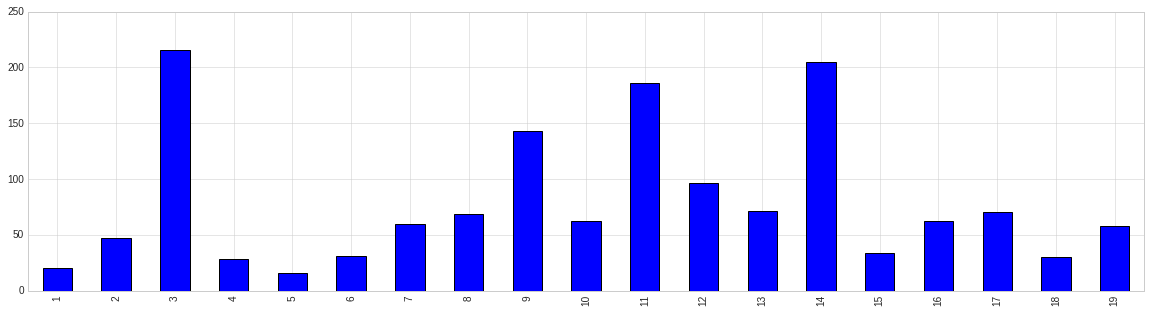

In [175]:
store_mse = {}
for i in model_df_base.store_nbr.unique():
  store_mse[i] = get_error(model_df_base[model_df_base["store_nbr"]==i]["perishable"].values * 0.25 + 1, model_df_base[model_df_base["store_nbr"]==i]['actual'].values, model_df_base[model_df_base["store_nbr"]==i]["pred_final"].values)
df_store_mse =pd.DataFrame(store_mse)
plt.figure(figsize=(20, 5))
df_store_mse.iloc[0,:].plot.bar()

In [166]:
stores[stores["store_nbr"].isin([3,9,11,14])]

,store_nbr,city,state,type,cluster,city_en,state_en,type_en
2,3,quito,Pichincha,D,8,18,12,3
8,9,quito,Pichincha,B,6,18,12,1
10,11,cayambe,Pichincha,B,6,2,12,1
13,14,riobamba,Chimborazo,C,7,19,2,2


In [134]:
stores[stores["type"].isin(["D","B"])]

,store_nbr,city,state,type,cluster,city_en,state_en,type_en
0,1,quito,Pichincha,D,13,18,12,3
1,2,quito,Pichincha,D,13,18,12,3
2,3,quito,Pichincha,D,8,18,12,3
3,4,quito,Pichincha,D,9,18,12,3
4,5,santo domingo,Santo Domingo de los Tsachilas,D,4,21,14,3
5,6,quito,Pichincha,D,13,18,12,3
6,7,quito,Pichincha,D,8,18,12,3
7,8,quito,Pichincha,D,8,18,12,3
8,9,quito,Pichincha,B,6,18,12,1
10,11,cayambe,Pichincha,B,6,2,12,1


In [167]:
stores[stores["cluster"].isin([6,7,8])]


,store_nbr,city,state,type,cluster,city_en,state_en,type_en
2,3,quito,Pichincha,D,8,18,12,3
6,7,quito,Pichincha,D,8,18,12,3
7,8,quito,Pichincha,D,8,18,12,3
8,9,quito,Pichincha,B,6,18,12,1
10,11,cayambe,Pichincha,B,6,2,12,1
13,14,riobamba,Chimborazo,C,7,19,2,2
19,20,quito,Pichincha,B,6,18,12,1
20,21,santo domingo,Santo Domingo de los Tsachilas,B,6,21,14,1
21,22,puyo,Pastaza,C,7,16,11,2
33,34,guayaquil,Guayas,B,6,8,6,1


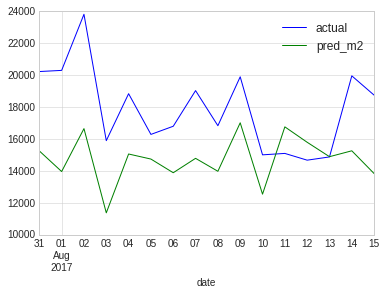

In [137]:
model_df_base[model_df_base["store_nbr"]==7][["date","actual","pred_m2"]].groupby("date").sum().plot()

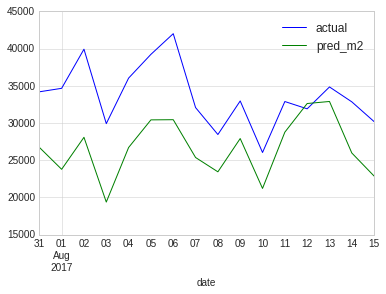

In [136]:
model_df_base[model_df_base["store_nbr"]==3][["date","actual","pred_m2"]].groupby("date").sum().plot()

In [180]:
model_df_base.family.unique()

array(['GROCERY I', 'BREAD/BAKERY', 'DELI', 'CLEANING', 'POULTRY',
       'PERSONAL CARE', 'LINGERIE', 'BEVERAGES', 'AUTOMOTIVE', 'DAIRY',
       'EGGS', 'GROCERY II', 'MEATS', 'FROZEN FOODS', 'HOME APPLIANCES',
       'SEAFOOD', 'PREPARED FOODS', 'LIQUOR,WINE,BEER', 'BEAUTY',
       'HARDWARE', 'LAWN AND GARDEN', 'PRODUCE', 'HOME AND KITCHEN II',
       'HOME AND KITCHEN I', 'MAGAZINES', 'HOME CARE', 'PET SUPPLIES',
       'PLAYERS AND ELECTRONICS', 'CELEBRATION',
       'SCHOOL AND OFFICE SUPPLIES', 'LADIESWEAR', 'BOOKS', 'BABY CARE'],
      dtype=object)

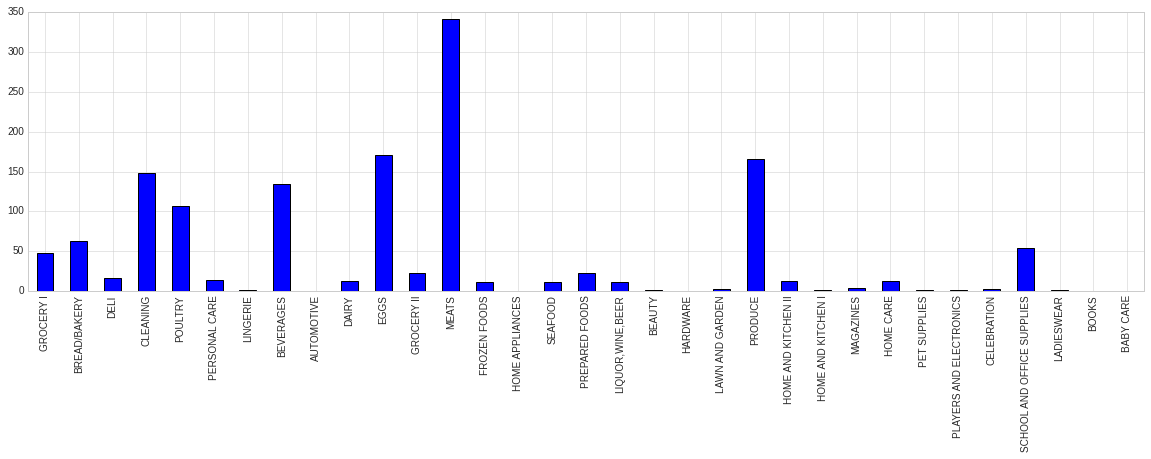

In [176]:
store_mse = {}
for i in model_df_base.family.unique():
  store_mse[i] = get_error(model_df_base[model_df_base["family"]==i]["perishable"].values * 0.25 + 1, model_df_base[model_df_base["family"]==i]['actual'].values, model_df_base[model_df_base["family"]==i]["pred_final"].values)
df_store_mse =pd.DataFrame(store_mse)
plt.figure(figsize=(20, 5))
df_store_mse.iloc[0,:].plot.bar()

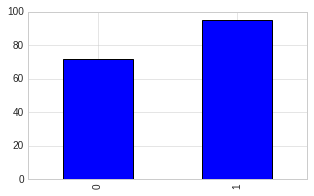

In [178]:
store_mse = {}
for i in model_df_base.perishable.unique():
  store_mse[i] = get_error(model_df_base[model_df_base["perishable"]==i]["perishable"].values * 0.25 + 1, model_df_base[model_df_base["perishable"]==i]['actual'].values, model_df_base[model_df_base["perishable"]==i]["pred_final"].values)
df_store_mse =pd.DataFrame(store_mse)
plt.figure(figsize=(5, 3))
df_store_mse.iloc[0,:].plot.bar()